# House price prediction

The purpose of this project is to construct models to predict sales prices for houses using Machine Learning regression techniques.  

We selected the Ames Housing dataset, made available by [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).  

The dataset contains 1460 complete samples with 80 attributes that vary from overal quality to garage conditions. A complete description of all attributes can be found in the data_description.txt file.  


## 1. Preprocessing

We begin by loading and preprocessing the data. In the pre processing step, we transform the raw data into useful inputs, checking for duplicates and missing values. A new column for price per square feet is also created to be used as a target varible. The transfomed data is ready to be loaded to a database and to be used for various visualization techniques and other applications. 

### 1.1. Load data and check for duplicates, missing values and correct data types


In [1]:
#import all the libraries used in this projects
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

from matplotlib import pyplot as plt
%matplotlib inline
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import train_test_split

The data loaded has the following data types: float64(3 columns), int64(35 columns), object(43 columns) with a total of 81 columns.

In [2]:
df= pd.read_csv('train.csv')
df.columns = df.columns.str.lower() 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

There are a total of 19 columns with null values in the data set. No duplicates were found.

In [3]:
if df.duplicated().any()== False:
    print("No duplicate values.")
else:
    print("There are duplicated values.")

col_isnull_any= []
for column in df.columns:
    if df[column].isnull().any():
        col_isnull_any.append(column)
print(f'Number of null columns: {len(col_isnull_any)}')
print(f'Columns with null values: {col_isnull_any}')


No duplicate values.
Number of null columns: 19
Columns with null values: ['lotfrontage', 'alley', 'masvnrtype', 'masvnrarea', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'electrical', 'fireplacequ', 'garagetype', 'garageyrblt', 'garagefinish', 'garagequal', 'garagecond', 'poolqc', 'fence', 'miscfeature']


We create list for different groups of features for different data types with the following criteria:
* categorical columns = columns with non numerical data types and numerical data types with unique values less or equal to 16.  
* numerical data types = columns with numerical data types and that are not in the categorical column.
* cardinal data types = categorical data types with more than 20 unique values
* ordinal data types = variables have natural, ordered categories and have rankings

In [4]:
#create categories
cat_thier=16
car_thier=20
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
cat_but_ord = ['lotshape', 'landslope', 'exterqual', 'extercond', 'bsmtqual', 
                'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heatingqc', 
                'kitchenqual', 'functional', 'fireplacequ', 'garagefinish', 'garagequal', 
                'garagecond', 'poolqc', 'fence', 'overallqual', 'overallcond']

cat_but_car = [col for col in df.columns if df[col].nunique() > car_thier and
                   df[col].dtypes == "O"]
num_but_cat = [col for col in df.columns if df[col].nunique() <= cat_thier and
                   df[col].dtypes != "O" and col not in cat_but_ord]

cat_cols = [col for col in cat_cols if col not in cat_but_car and cat_but_ord]
cat_cols = cat_cols + num_but_cat

# count and list the created groups.
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
num_cols = [col for col in num_cols if col not in num_but_cat and col not in cat_but_ord]


print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f'cat_cols: {len(cat_cols)}')
print(f'num_cols: {len(num_cols)}')
print(f'cat_but_car: {len(cat_but_car)}')
print(f'cat_but_ord: {len(cat_but_ord)}') 
print(f'num_but_cat: {len(num_but_cat)}')
print(f"""Categorical Variables={cat_cols}, \nNumerical Variables={num_cols}, \nNumerical but categorical={num_but_cat},
        \nCategorical but Cardinal Variables={cat_but_car}, \nCategorical but Ordinal Variables={cat_but_ord}""")

Observations: 1460
Variables: 81
cat_cols: 55
num_cols: 23
cat_but_car: 1
cat_but_ord: 20
num_but_cat: 13
Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'mssubclass', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'poolarea', 'mosold', 'yrsold'], 
Numerical Variables=['id', 'lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsm

<function matplotlib.pyplot.show(close=None, block=None)>

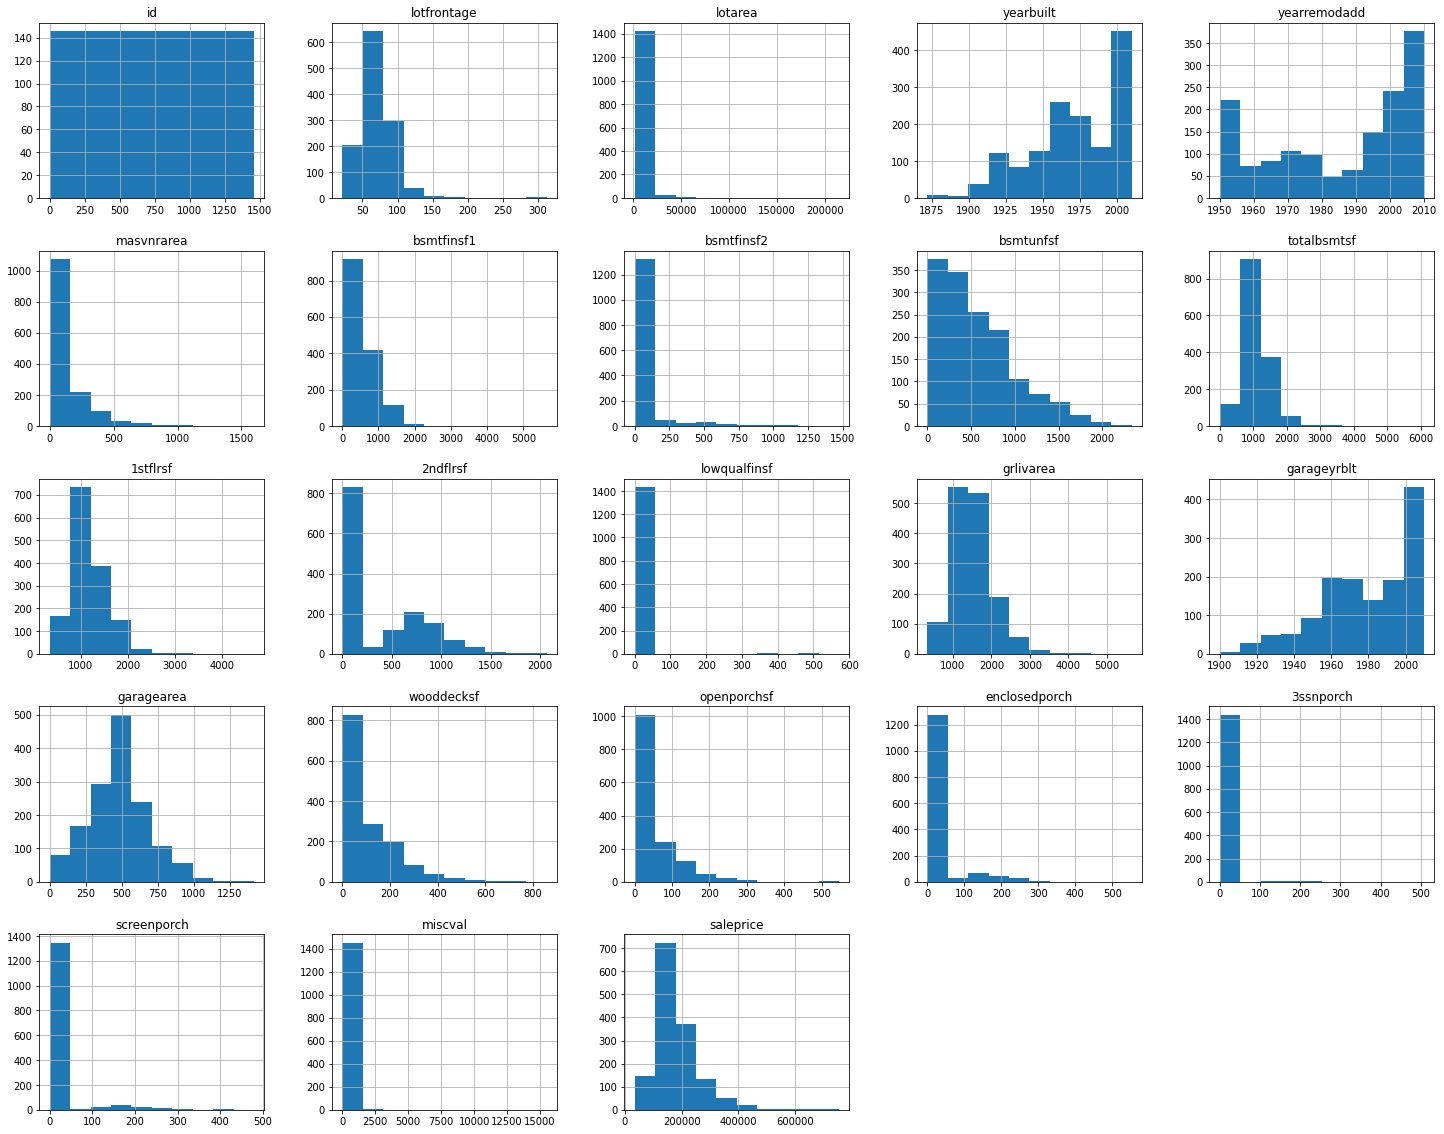

In [5]:
df[num_cols].hist(figsize=(25,20))
plt.show

### 1.2 Creating a target variable and looking for outliers

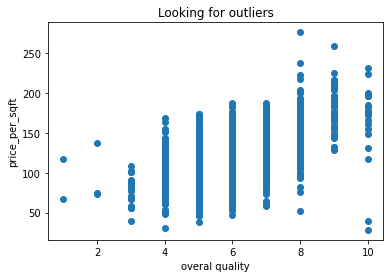

In [6]:
df['price_per_sqft'] = df['saleprice']/ df['grlivarea']
plt.scatter(df.overallqual, df.price_per_sqft)
plt.title("Looking for outliers")
plt.xlabel("overal quality")
plt.ylabel('price_per_sqft')
plt.show()

In [7]:
df= df[(df['overallqual']!='10') & (df['price_per_sqft']>50)]
df.shape

(1449, 82)

### 1.2. Transform data that has missing values

To transform data that have missing values, we follow the following criteria:
* Columns with most null values: replace with none, since they are nested variables
* Columns with dominant values: replace it with none
* Columns with missing values: if they are not most null, with replace them with median values (if they are numerical) or mode (if they are categorical).

In [8]:
most_null = []
for i in df.columns:
    null = df[df[i].isnull()]
    if len(null) > 0.3*len(df.index):
        most_null.append(i)
print(most_null)

['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature']


In [9]:
df[most_null] = df[most_null].fillna("None")
df[most_null].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   alley        1449 non-null   object
 1   fireplacequ  1449 non-null   object
 2   poolqc       1449 non-null   object
 3   fence        1449 non-null   object
 4   miscfeature  1449 non-null   object
dtypes: object(5)
memory usage: 67.9+ KB


In [10]:
#Replace with none

for col in ('garagetype', 'garagefinish', 'garagequal', 'garagecond'):
        df[col] = df[col].fillna('None')

for col in ('garageyrblt', 'garagearea', 'garagecars'):
        df[col]= df[col].fillna(0)
for col in ('bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf','totalbsmtsf', 'bsmtfullbath', 'bsmthalfbath'):
    df[col] = df[col].fillna(0)

for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
    df[col] = df[col].fillna('None')


#Replace missing data with median or mode

df["lotfrontage"] = df.groupby("neighborhood")["lotfrontage"].transform(lambda x: x.fillna(x.median()))

df['mszoning'] = df['mszoning'].fillna(df['mszoning'].mode()[0])
df['electrical'] = df['electrical'].fillna(df['electrical'].mode()[0])
df['kitchenqual'] = df['kitchenqual'].fillna(df['kitchenqual'].mode()[0])
df["functional"] = df["functional"].fillna("typ")
df["masvnrtype"] = df["masvnrtype"].fillna(df["masvnrtype"].mode()[0])
df["masvnrarea"] = df["masvnrarea"].fillna(df["masvnrarea"].mode()[0])




We check if there are any missing values remaining

In [11]:
df.isnull().values.any()

False

### 1.3. Transform data that has the incorrect data type

Type of dwelling is encoded as a numerical data type and needs to be transformed into string type.
Since year and month sold falls into the categorical data criteria, they are also transformed into string type.

In [12]:
#Year sold, month sold  and type of dweling re transformed into categorical features.
df['mssubclass'] = df['mssubclass'].astype(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)

print(f"Categorical Variables={cat_cols}")

Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'mssubclass', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'poolarea', 'mosold', 'yrsold']


### 1.4. Remove variables that are almost constant

In [13]:
#remove column with almost constant values

#Drop variables
df = df.drop(['utilities'], axis=1)

cat_cols.remove('utilities')
print(f"Categorical Variables={cat_cols}")

Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'mssubclass', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'poolarea', 'mosold', 'yrsold']


In [14]:
df.to_csv('transformed.csv')

print(f"All columns={df.columns}")

All columns=Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', '1stflrsf', '2ndflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive'

### 1.5. Feature engineering: transform ordinal data types

In [15]:
for col in df[cat_but_ord].columns:
    print(f'{col} : {df[col].unique()}')

lotshape : ['Reg' 'IR1' 'IR2' 'IR3']
landslope : ['Gtl' 'Mod' 'Sev']
exterqual : ['Gd' 'TA' 'Ex' 'Fa']
extercond : ['TA' 'Gd' 'Fa' 'Po' 'Ex']
bsmtqual : ['Gd' 'TA' 'Ex' 'None' 'Fa']
bsmtcond : ['TA' 'Gd' 'None' 'Fa' 'Po']
bsmtexposure : ['No' 'Gd' 'Mn' 'Av' 'None']
bsmtfintype1 : ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
bsmtfintype2 : ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
heatingqc : ['Ex' 'Gd' 'TA' 'Fa' 'Po']
kitchenqual : ['Gd' 'TA' 'Ex' 'Fa']
functional : ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
fireplacequ : ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
garagefinish : ['RFn' 'Unf' 'Fin' 'None']
garagequal : ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
garagecond : ['TA' 'None' 'Gd' 'Fa' 'Po' 'Ex']
poolqc : ['None' 'Ex' 'Fa' 'Gd']
fence : ['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
overallqual : [ 7  6  8  5  9  4 10  3  1  2]
overallcond : [5 8 6 7 4 2 3 9 1]


In [16]:
df= df.replace({"bsmtcond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                "bsmtexposure" : {"None" : 0, "No": 1, "Mn" : 2, "Av": 3, "Gd" : 4},
                "bsmtfintype1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                "bsmtfintype2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                "bsmtqual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                "extercond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
              "exterqual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
              "fireplacequ" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
              "functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
              "garagecond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
              "garagefinish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
              "garagequal" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
              "heatingqc" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
              "kitchenqual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
              "landslope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
              "lotshape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
              "poolqc" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
              "fence" : {"None":0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv":4},
              })
        
              

In [17]:
for col in df[cat_but_ord].columns:
    print(f'{col} : {df[col].unique()}')

lotshape : [4 3 2 1]
landslope : [3 2 1]
exterqual : [4 3 5 2]
extercond : [3 4 2 1 5]
bsmtqual : [4 3 5 0 2]
bsmtcond : [3 4 0 2 1]
bsmtexposure : [1 4 2 3 0]
bsmtfintype1 : [6 5 1 3 4 0 2]
bsmtfintype2 : [1 4 0 5 3 2 6]
heatingqc : [5 4 3 2 1]
kitchenqual : [4 3 5 2]
functional : [8 7 4 6 5 3 2]
fireplacequ : [0 3 4 2 5 1]
garagefinish : [2 1 3 0]
garagequal : [3 2 4 0 5 1]
garagecond : [3 0 4 2 1 5]
poolqc : [0 4 1 3]
fence : [0 3 2 4 1]
overallqual : [ 7  6  8  5  9  4 10  3  1  2]
overallcond : [5 8 6 7 4 2 3 9 1]


<function matplotlib.pyplot.show(close=None, block=None)>

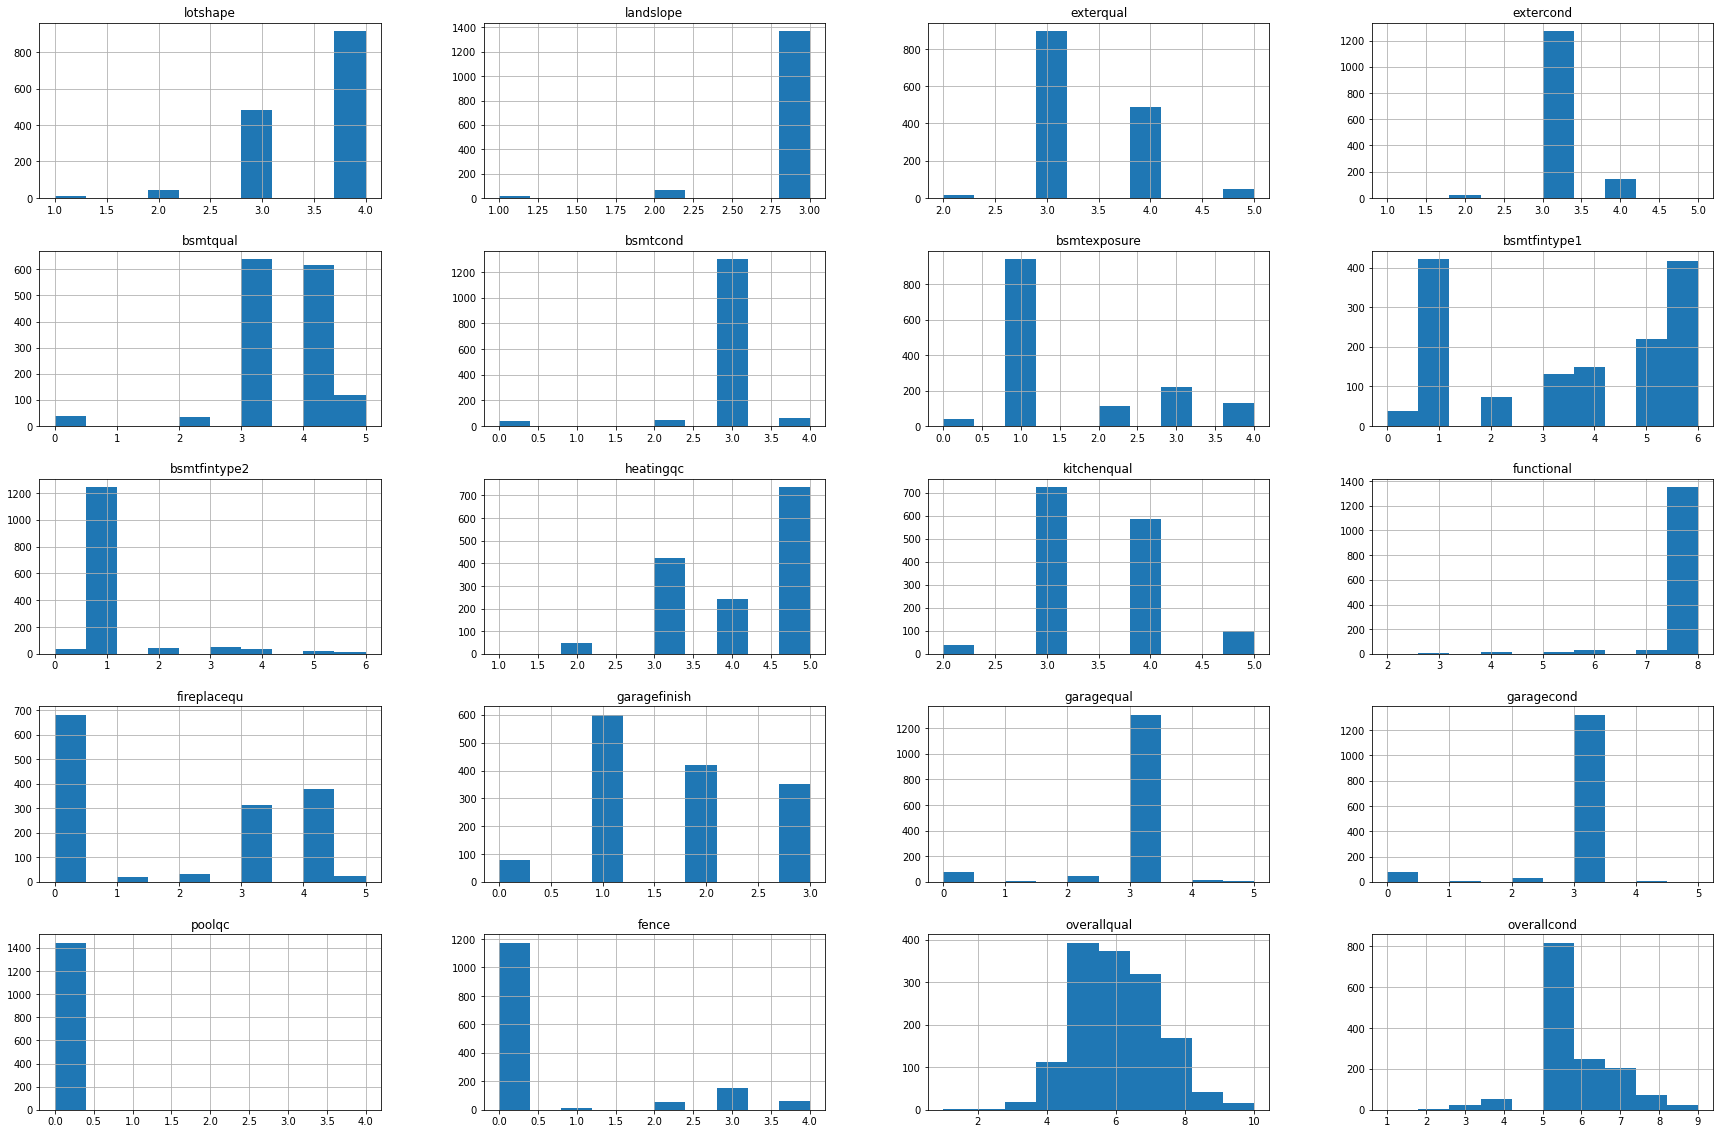

In [18]:
df[cat_but_ord].hist(figsize=(30,20))
plt.show

## 2. Exploratory analysis

### 2.1. Selecting relevant variables

Variables related to the size of the houses are removed.

In [19]:
to_remove= ['saleprice', '1stflrsf', '2ndflrsf', 'grlivarea', 'id', 'neighborhood']
df_clean = df.drop(to_remove, axis=1)

for i in to_remove:
    if i in num_cols:
        num_cols.remove(i)
print(f"All columns={df_clean.columns}")
print

All columns=Index(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'lotconfig', 'landslope', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual', 'extercond',
       'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',
       'bsmtfinsf1', 'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       'heating', 'heatingqc', 'centralair', 'electrical', 'lowqualfinsf',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 'functional',
       'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch',
     

<function print>

### 2.2. Analyzing correlations

<AxesSubplot:>

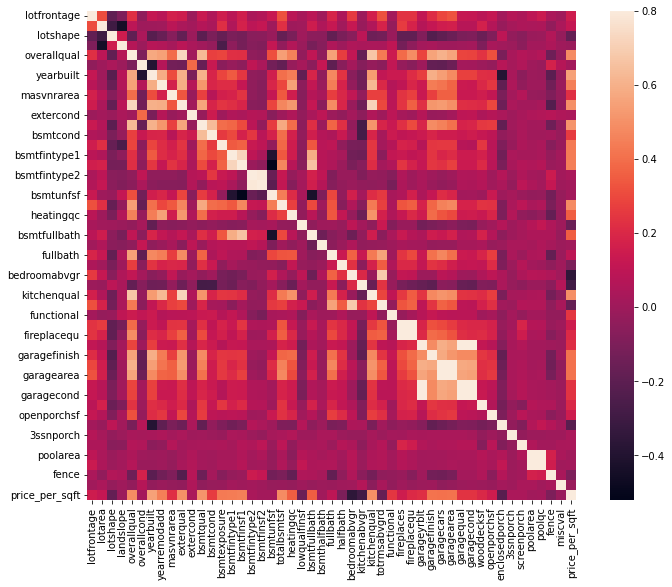

In [20]:
corrmat = df_clean.corr()
f,ax =plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

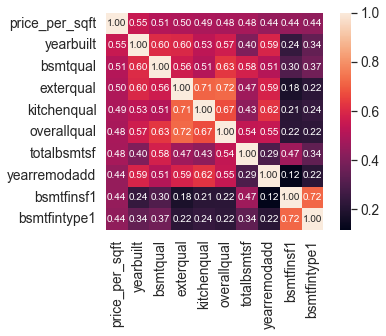

In [21]:
k = 10 #number of variables for heatmap
cols =corrmat.nlargest(k,'price_per_sqft')['price_per_sqft'].index
cm =np.corrcoef(df_clean[cols].values.T)
sns.set(font_scale=1.25)
hm =sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The list bellow shows the 20 features with the highest correlation in relation to price per square feet in absolute terms.

In [22]:
corrmat = df_clean.corr()
np.absolute(corrmat['price_per_sqft']).sort_values(ascending=False).head(20)

price_per_sqft    1.000000
yearbuilt         0.550741
bsmtqual          0.509306
exterqual         0.499224
kitchenqual       0.490999
overallqual       0.483995
totalbsmtsf       0.480513
yearremodadd      0.444373
bsmtfinsf1        0.444210
bsmtfintype1      0.435308
bsmtexposure      0.430560
garagefinish      0.412239
garagearea        0.410319
garagecars        0.405279
bedroomabvgr      0.357756
bsmtfullbath      0.351836
heatingqc         0.351823
kitchenabvgr      0.289311
bsmtcond          0.259393
functional        0.243069
Name: price_per_sqft, dtype: float64

In [23]:
#delete one of two high correlated features
to_remove = ['garagearea']
df_clean = df_clean.drop(to_remove, axis=1)

for i in to_remove:
    if i in cat_cols:
        cat_cols.remove(i)

df_clean.shape

(1449, 74)

In [24]:
#creating a low correlation group
corrmat = df_clean.corr()
corr = np.absolute(corrmat['price_per_sqft'])
low_corr=corr.index[corr<0.3].tolist()
df_clean.drop(low_corr, axis=1)

#eliminating a low correlation group
for i in low_corr:
    if i in cat_cols:
       cat_cols.remove(i)


The figure bellow shows the correlation between year built, year remodelled, overallquality and price per square feet.

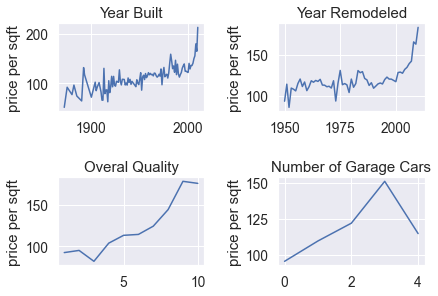

In [25]:
dfgroupby_yearbuilt= df_clean.groupby("yearbuilt", as_index=False)["price_per_sqft"].mean()
dfgroupby_yearremodad= df_clean.groupby("yearremodadd", as_index=False)["price_per_sqft"].mean()
dfgroupby_overallqual= df_clean.groupby("overallqual", as_index=False)["price_per_sqft"].mean()
dfgroupby_garagecars= df_clean.groupby("garagecars", as_index=False)["price_per_sqft"].mean()

plt.figure(1)
plt.subplot(221)
plt.plot(dfgroupby_yearbuilt.yearbuilt, dfgroupby_yearbuilt.price_per_sqft)
plt.title('Year Built')
plt.ylabel('price per sqft')

plt.figure(1)
plt.subplot(222)
plt.plot(dfgroupby_yearremodad.yearremodadd, dfgroupby_yearremodad.price_per_sqft)
plt.title('Year Remodeled')
plt.ylabel('price per sqft')

plt.figure(1)
plt.subplot(223)
plt.plot(dfgroupby_overallqual.overallqual, dfgroupby_overallqual.price_per_sqft)
plt.title('Overal Quality')
plt.ylabel('price per sqft')

plt.figure(1)
plt.subplot(224)
plt.plot(dfgroupby_garagecars.garagecars, dfgroupby_garagecars.price_per_sqft)
plt.title('Number of Garage Cars')
plt.ylabel('price per sqft')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.75,
                    wspace=0.50)
plt.show()

## 3. Data Modeling and Predictions

### 3.1. Making lables for classes

In [26]:
def encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_clean = encoder(df_clean,cat_cols,drop_first=True)
df_clean.shape

(1449, 231)

### 3.2. Spliting dataset into train and test sets

In [27]:
y = df_clean['price_per_sqft']
X = df_clean.drop(['price_per_sqft'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1086, 230) (363, 230)
(1086,) (363,)


### 3.3. Normalizing the data

The data is normalized using the following criteria:
* Target Value = log-normalization
* Features = standardization

C:\Users\hmari\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price_per_sqft', ylabel='Density'>

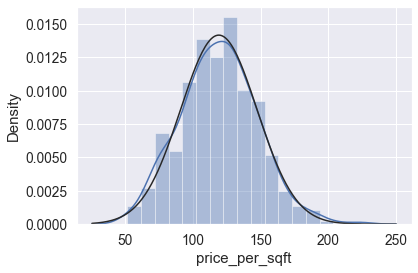

In [28]:
sns.distplot(y_test , fit=norm)

C:\Users\hmari\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price_per_sqft', ylabel='Density'>

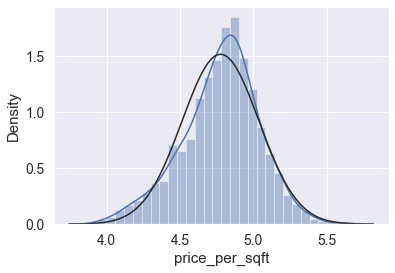

In [29]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
 
sns.distplot(y_train , fit=norm)

### 3.5. Creating cross validation scores for several models using mean square errors

In [30]:
#create models

models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE train: {round(rmse, 4)} ({name}) ")

RMSE train: 0.1429 (LR) 
RMSE train: 0.1331 (Ridge) 
RMSE train: 0.2007 (Lasso) 
RMSE train: 0.195 (ElasticNet) 
RMSE train: 0.2349 (KNN) 
RMSE train: 0.2071 (CART) 
RMSE train: 0.1417 (RF) 
RMSE train: 0.2222 (SVR) 
RMSE train: 0.1369 (GBM) 
RMSE train: 0.1353 (LightGBM) 


In [31]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE test: {round(rmse, 4)} ({name}) ")

RMSE test: 0.2359 (LR) 
RMSE test: 0.1709 (Ridge) 
RMSE test: 0.213 (Lasso) 
RMSE test: 0.215 (ElasticNet) 
RMSE test: 0.2276 (KNN) 
RMSE test: 0.1919 (CART) 
RMSE test: 0.1514 (RF) 
RMSE test: 0.2244 (SVR) 
RMSE test: 0.1393 (GBM) 
RMSE test: 0.1505 (LightGBM) 


### 3.4. Testing parameters for GBM

In [32]:
gb = GradientBoostingRegressor()
params_gb = {
    'loss' : ('squared_error', 'absolute_error','huber'),
    'learning_rate' : (1.0, 0.1, 0.01),
    'n_estimators' : (100, 200, 300)
}

mod_gb = GridSearchCV(gb, params_gb, cv=10)
mod_gb.fit(X_train, y_train)
print('Best_hyperparameter : ', mod_gb.best_params_)

pred_gb_train = mod_gb.predict(X_train)
print(f'RMSE train: {mean_squared_error(y_train,pred_gb_train, squared=False)}')

pred_gb_test = mod_gb.predict(X_test)
print(f'RMSE train: {mean_squared_error(y_test,pred_gb_test, squared=False)}')

Best_hyperparameter :  {'learning_rate': 0.1, 'loss': 'absolute_error', 'n_estimators': 300}
RMSE train: 0.09553990471637683
RMSE train: 0.12426212324707933


In [33]:
final_model = gb.set_params(**mod_gb.best_params_).fit(X_train,y_train)
rmse_train = np.mean(np.sqrt(-cross_val_score(final_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")))
rmse_test = np.mean(np.sqrt(-cross_val_score(final_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
print(rmse_train)
print(rmse_test)

0.13306122859687144
0.1394514380739416


The graph bellow shows the test set deviance and then plot it against boosting iterations.

C:\Users\hmari\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


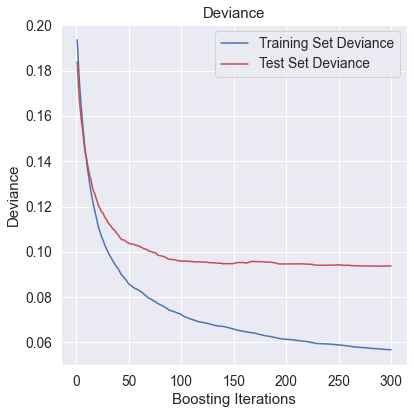

In [40]:
reg = gb.set_params(**mod_gb.best_params_)
test_score = np.zeros((mod_gb.best_params_["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(mod_gb.best_params_["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(mod_gb.best_params_["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

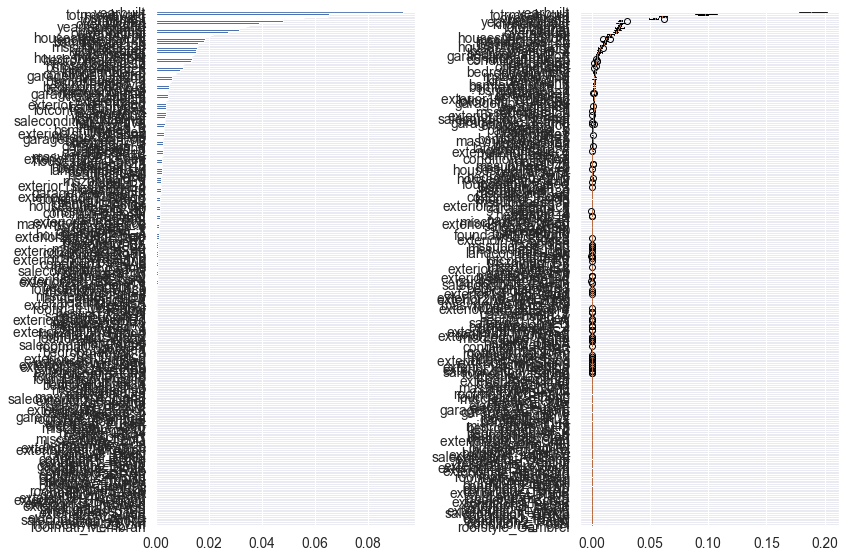

In [41]:
from sklearn.inspection import permutation_importance

result = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

importance_sorted_idx = np.argsort(reg.feature_importances_)
gb_indices = np.arange(0, len(reg.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(gb_indices, reg.feature_importances_[importance_sorted_idx], height=0.7)
ax1.set_yticks(gb_indices)
ax1.set_yticklabels(X.columns[importance_sorted_idx])
ax1.set_ylim((0, len(reg.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

Testing Random Forest Regressor and feature importances

In [42]:
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
print("Features sorted by their score:")
(sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), df_clean.columns), reverse=True))

#print(sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), df_clean.columns), reverse=True))
#plt.barh(df_clean.columns, RF.feature_importances_)



Features sorted by their score:


[(0.2709, 'yearbuilt'),
 (0.0848, 'bsmtfinsf1'),
 (0.0701, 'totrmsabvgrd'),
 (0.0646, 'totalbsmtsf'),
 (0.0563, 'overallcond'),
 (0.0358, 'housestyle_1.5Unf'),
 (0.0337, 'mssubclass_190'),
 (0.0279, 'yearremodadd'),
 (0.0235, 'garageyrblt'),
 (0.02, 'lotarea'),
 (0.0192, 'bsmtunfsf'),
 (0.0181, 'kitchenabvgr'),
 (0.0179, 'overallqual'),
 (0.0139, 'functional'),
 (0.0119, 'mssubclass_45'),
 (0.0106, 'lotfrontage'),
 (0.0084, 'housestyle_2.5Unf'),
 (0.0071, 'openporchsf'),
 (0.0062, 'halfbath'),
 (0.0059, 'bsmtexposure_2'),
 (0.0058, 'wooddecksf'),
 (0.0058, 'kitchenqual_4'),
 (0.0055, 'bsmtqual_4'),
 (0.0051, 'masvnrarea'),
 (0.0049, 'bsmtcond'),
 (0.0047, 'fireplacequ'),
 (0.0046, 'enclosedporch'),
 (0.0043, 'salecondition_Alloca'),
 (0.0043, 'bsmtqual_5'),
 (0.0041, 'fullbath'),
 (0.0038, 'mosold_12'),
 (0.0036, 'mssubclass_90'),
 (0.0031, 'kitchenqual_3'),
 (0.003, 'bedroomabvgr_2'),
 (0.0029, 'mszoning_RH'),
 (0.0028, 'paveddrive_P'),
 (0.0028, 'fireplaces'),
 (0.0027, 'saleconditio

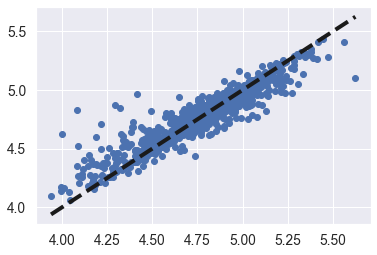

In [43]:
fig, ax = plt.subplots()
ax.scatter(y_train, pred_gb_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=4)
plt.show()

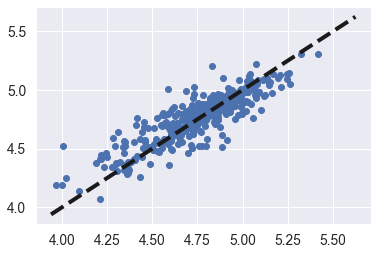

In [44]:
fig, ax = plt.subplots()
ax.scatter(y_test, pred_gb_test)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=4)
plt.show()

### 3.5. Creating and export prediction values

In [37]:
GBM = GradientBoostingRegressor()
RF = RandomForestRegressor()
LGBM = LGBMRegressor()
GBM.fit(X_train, y_train)
RF.fit(X_train, y_train)
LGBM.fit(X_train, y_train)
y_test_pred_GBM = GBM.predict(X_test)
y_train_pred_GBM = GBM.predict(X_train)
y_test_pred_RF = GBM.predict(X_test) 
y_train_pred_RF = RF.predict(X_train)
y_test_pred_LGBM = LGBM.predict(X_test)
y_train_pred_LGBM = LGBM.predict(X_train)

In [38]:
y_test_pred_GBM = np.expm1(y_test_pred_GBM)
y_train_pred_GBM = np.expm1(y_train_pred_GBM)
y_test_pred_RF = np.expm1(y_test_pred_RF)
y_train_pred_RF = np.expm1(y_train_pred_RF)
y_test_pred_LGBM = np.expm1(y_test_pred_LGBM)
y_train_pred_LGBM = np.expm1(y_train_pred_LGBM)
y_test = np.expm1(y_test)
pred_gb_test = np.expm1(pred_gb_test)

In [39]:
predictions= {'realprice':y_test ,'y_gmb': y_test_pred_GBM, 'y_rf': y_test_pred_RF, 'y_lgbm': y_test_pred_LGBM, 'y_gbm_adj': pred_gb_test}
predictions= pd.DataFrame(predictions)
predictions.to_csv('predictions.csv')